# Create random initial data for noise estimation and analysis for 3 nominally identical 3D printers case study

written by Christina Schenk

last updated on 23 Oct 2025

tested on Christina's Mac

This notebook creates an initial dataset for performing Bayesian optimization for optimizing printing parameters targeting density/weight and noise estimation

This is shows the initial data creation for the "Noise-Aware Optimization in Nominally Identical Measuring Systems for High-Throughput Parallel Workflows" Manuscript by Christina Schenk et al. (2025).

The steps of the workflow are the following:

* Import data set and initialize setting
* Generate random initial dataset
* Write to file

In [1]:
import os
import pandas as pd
import numpy as np
from gpcam import GPOptimizer,AutonomousExperimenterGP
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

## Define design setting

In [2]:
#Lower and upper bounds for the parameters:
#speed fixed at 100 and LW at 0.8
f_lb = 1000
f_ub = 5000
lh_lb = 0.2
lh_ub = 0.6

#number of points in x and y direction at which we want to predict:
n_pts = 100

#number of autonomous experiments that you would like to run:
N_exp = 19

#dimension of design space:
dim = 2

## Initialization

In [3]:
parameter_bounds = np.array([[f_lb,f_ub], [lh_lb, lh_ub]])

## Data

In [4]:
data = pd.read_excel("./data//data_noise_LPLA_refpoint.xlsx")

In [5]:
wmeanrep1 = data.loc[0:2, 'Wmean'].mean()

In [6]:
data.loc[0:2, 'Wmean']

0    4.644000
1    4.655333
2    4.525000
Name: Wmean, dtype: float64

In [7]:
wmeanrep1

4.608111111

In [8]:
data_ref1 = data.loc[0,['Flow', 'LH', 'Wmean']]
data_ref1.loc['Wmean'] = wmeanrep1

In [9]:
data_ref1

Flow       3000.0
LH            0.4
Wmean    4.608111
Name: 0, dtype: object

In [10]:
data_array_ref1 = np.array(data_ref1)
np.save('./data/data-init_ref1.npy', data_array_ref1)
data_path = "../data"
data_npy = np.load(os.path.join(data_path,"data-init_ref1.npy"), allow_pickle=True)
print(np.shape(data_npy))
points = data_npy[0:dim]
values = data_npy[dim:dim+1]


(3,)


In [11]:
#it is good practice to check the format of the data
print(points.shape)
print(values.shape)
print(points)
print(values)

(2,)
(1,)
[3000.0 0.4]
[4.608111111]


#### Define some points at which we will predict, still has nothing to do with gpCAM 

In [12]:
x_pred = np.zeros((n_pts*n_pts,2))
x = np.linspace(f_lb,f_ub,n_pts)
y = np.linspace(lh_lb,lh_ub,n_pts)
X,Y = np.meshgrid(x,y)
counter = 0
for i in  range(n_pts):
    for j in range(n_pts):
        x_pred[counter] = np.array([X[i,j],Y[i,j]])
        counter += 1

## Create random dataset

In [13]:
n_initdata = N_exp
#Just for creation of random dataset, rest we will do with gpOptimizer and our own loop
def instrument(data, instrument_dict = {}):
    for entry in data:
        print("Suggested by gpCAM: ", entry["x_data"])
        entry["y_data"] = griddata(x,y,entry["x_data"],method = "nearest", fill_value = 0)[0]
    print("")
    return data
    
my_ae = AutonomousExperimenterGP(parameter_bounds,
                                 init_dataset_size=n_initdata, instrument_function = instrument)

randomarray = np.vstack([my_ae.data.dataset[i]["x_data"] for i in range(n_initdata)])
print(randomarray)

Suggested by gpCAM:  [2.80293961e+03 5.78817018e-01]
Suggested by gpCAM:  [2.58436145e+03 5.97435264e-01]
Suggested by gpCAM:  [1.88963245e+03 2.42580024e-01]
Suggested by gpCAM:  [2.91643236e+03 4.86466444e-01]
Suggested by gpCAM:  [1.67483796e+03 5.54070523e-01]
Suggested by gpCAM:  [2.53761039e+03 4.78227464e-01]
Suggested by gpCAM:  [3.48737936e+03 3.40505639e-01]
Suggested by gpCAM:  [4.70685686e+03 4.19126259e-01]
Suggested by gpCAM:  [4.94922786e+03 2.25240715e-01]
Suggested by gpCAM:  [1.37892718e+03 5.24839210e-01]
Suggested by gpCAM:  [3.84721957e+03 2.82876567e-01]
Suggested by gpCAM:  [2.10874863e+03 3.24688979e-01]
Suggested by gpCAM:  [2.82767665e+03 2.47298965e-01]
Suggested by gpCAM:  [4.38029888e+03 5.96649779e-01]
Suggested by gpCAM:  [3.18203388e+03 2.02323038e-01]
Suggested by gpCAM:  [3.11038989e+03 2.71116590e-01]
Suggested by gpCAM:  [1.22834695e+03 3.99157901e-01]
Suggested by gpCAM:  [4.58623317e+03 3.89410190e-01]
Suggested by gpCAM:  [4.67089922e+03 2.3458970

/Users/christinaschenk/Programs/LabAutomation/gpcam8imatepip_env/lib/python3.9/site-packages/gpcam/gp_optimizer.py:343: UserWarning: No noise function or measurement noise provided. Noise variances will be set to 1% of mean(y_data).
  super().__init__(


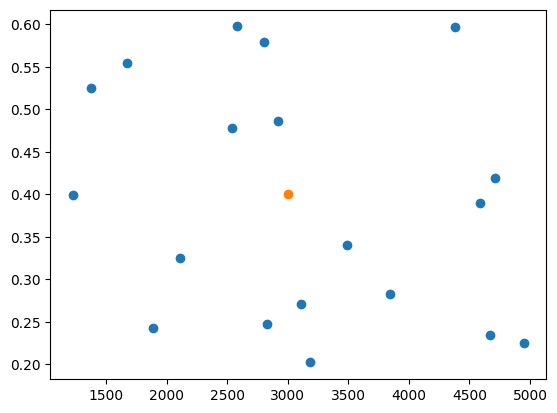

In [15]:
plt.scatter(randomarray[:,0], randomarray[:,1])
plt.scatter(points[0], points[1])
plt.savefig('scatterplot_randompts.png')

In [16]:
printid = np.array([1,2])
allprintid0 = np.repeat(int(printid[0]), len(randomarray))
allprintid1 = np.repeat(int(printid[1]), len(randomarray))
allprintid0 = np.array(allprintid0, dtype=int).reshape(-1,1)
allprintid1 = np.array(allprintid1, dtype=int).reshape(-1,1)
random_all_comps_rep0 = np.hstack((randomarray, allprintid0))
random_all_comps_rep1 = np.hstack((randomarray, allprintid1))
random_all_comps_rep = np.vstack((random_all_comps_rep0, random_all_comps_rep1))

In [17]:
#Just take first 6 points
data_new = data.iloc[0:6,:]
#remove Unnamed columns
data_new = data_new.loc[:, ~data_new.columns.str.contains('^Unnamed')]
#repeat each entry 3 times for consecutive repetitions
random_all_comps_rep_all = np.repeat(random_all_comps_rep, 3, axis=0)

In [18]:
data_new2 = data_new

In [19]:
#add empty rows for adding new suggestions to excel file
empty_rows = pd.DataFrame(columns=data_new.columns, index=range(len(random_all_comps_rep_all)))
data_new2 = pd.concat([data_new, empty_rows], ignore_index=True)

/var/folders/63/vmpx1vmx3s59d2ky2fm1zzww0000gp/T/ipykernel_3920/2128979684.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_new2 = pd.concat([data_new, empty_rows], ignore_index=True)


In [20]:
data_new2

,Flow,LH,PrintID,Rep,Wmean,W1,W2,W3,Operator,Date,Start Time
0,3000.0,0.4,1.0,1.0,4.644000,4.675,4.469,4.788,BS,2024-06-13,13:00:00
1,3000.0,0.4,1.0,2.0,4.655333,4.532,4.733,4.701,BS,2024-06-13,14:00:00
2,3000.0,0.4,1.0,3.0,4.525000,4.620,4.472,4.483,BS,2024-06-13,15:00:00
3,3000.0,0.4,2.0,1.0,3.621000,3.712,3.680,3.471,BS,2024-06-13,14:00:00
4,3000.0,0.4,2.0,2.0,3.433667,3.248,3.512,3.541,BS,2024-06-13,15:00:00
...,...,...,...,...,...,...,...,...,...,...,...
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [21]:
#write new suggestions to data frame:
for i in range(len(random_all_comps_rep_all)):
    data_new2.loc[6+i,'Flow'] = random_all_comps_rep_all[i,0]
    data_new2.loc[6+i,'LH'] = random_all_comps_rep_all[i,1]
    data_new2.loc[6+i,'PrintID'] = random_all_comps_rep_all[i,2] 

In [22]:
#add consecutive reps to dataframe
j=0
while j < len(data_new2):
    data_new2.loc[j,'Rep'] = 1
    data_new2.loc[j+1,'Rep'] = 2
    data_new2.loc[j+2,'Rep'] = 3
    j=j+3

In [23]:
data_new2

,Flow,LH,PrintID,Rep,Wmean,W1,W2,W3,Operator,Date,Start Time
0,3000.000000,0.40000,1.0,1.0,4.644000,4.675,4.469,4.788,BS,2024-06-13,13:00:00
1,3000.000000,0.40000,1.0,2.0,4.655333,4.532,4.733,4.701,BS,2024-06-13,14:00:00
2,3000.000000,0.40000,1.0,3.0,4.525000,4.620,4.472,4.483,BS,2024-06-13,15:00:00
3,3000.000000,0.40000,2.0,1.0,3.621000,3.712,3.680,3.471,BS,2024-06-13,14:00:00
4,3000.000000,0.40000,2.0,2.0,3.433667,3.248,3.512,3.541,BS,2024-06-13,15:00:00
...,...,...,...,...,...,...,...,...,...,...,...
115,4586.233170,0.38941,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
116,4586.233170,0.38941,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
117,4670.899219,0.23459,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
118,4670.899219,0.23459,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [24]:
data_new2.to_excel("../data/data_noise_LPLA_random.xlsx") 

In [25]:
#np.savetxt('../data/initrandomdata.csv', random_all_comps_rep,  
              #delimiter = ",", header="Flow,LayerHeight,PrintID", comments="")